In [1]:
#Compute RMSE between GLORYS and CORA and save both profiles in a netcdf - November 2021
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm

from keras import backend as K

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
import gsw
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '../cartopy_shapefiles'

In [2]:
x_glo = xr.open_dataset('/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_Interp_Final.nc')
x_glo = x_glo.where(x_glo.depth<1001,drop = True)
x_glo

<xarray.Dataset>
Dimensions:        (N_PROF: 443, depth: 35)
Coordinates:
    longitude      (N_PROF) float32 ...
    latitude       (N_PROF) float32 ...
  * depth          (depth) float32 0.494 1.541 2.646 3.819 ... 643.6 763.3 902.3
    time           (N_PROF) datetime64[ns] ...
    LONGITUDE      (N_PROF) float64 ...
    LATITUDE       (N_PROF) float64 ...
    TIME           (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables: (12/25)
    mlotst         (N_PROF, depth) float32 64.85 64.85 64.85 ... 148.5 148.5
    zos            (N_PROF, depth) float32 -0.9153 -0.9153 ... -0.8957 -0.8957
    bottomT        (N_PROF, depth) float32 -1.225 -1.225 ... -1.161 -1.161
    sithick        (N_PROF, depth) float32 nan nan nan nan ... nan nan nan nan
    siconc         (N_PROF, depth) float32 nan nan nan nan ... nan nan nan nan
    usi            (N_PROF, depth) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...             ...
    SIG_predicted  (N_PROF, depth) float64 27.91 27.91 27.91 ... 28.06 28.06
    ae_so_surf     (N_PROF, depth) float64 0.05342 0.05342 ... 0.002825
    ae_to_surf     (N_PROF, depth) float64 0.7668 0.7676 ... 0.0172 0.005077
    ae_SIG         (N_PROF, depth) float64 0.01782 0.01779 ... 0.002506
    ae_so          (N_PROF, depth) float64 0.05342 0.05342 ... 0.002825
    ae_to          (N_PROF, depth) float64 0.7668 0.7676 ... 0.0172 0.005077
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/04/06 14:05:19 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [3]:
#Compute GLORYS RMSE weighted by depth levels
#RMSE function
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

rmse_T = rmse_from_ae(x_glo['ae_to'])
rmse_S = rmse_from_ae(x_glo['ae_so'])
rmse_SIG = rmse_from_ae(x_glo['ae_SIG'])
x_glo = x_glo.assign(variables={"rmse_T": (('depth'), rmse_T.data)})
x_glo = x_glo.assign(variables={"rmse_S": (('depth'), rmse_S.data)})
x_glo = x_glo.assign(variables={"rmse_SIG": (('depth'), rmse_SIG.data)})

In [4]:
#Creation of delta z (shift and add a 46m)
p = x_glo.depth
dz = np.ones(len(p))
for n in np.arange(0,len(p)-1):
    dz[n+1] = p[n+1]-p[n]
dzs = list(dz[1:35])
dzs.append(46.0)
len(dzs)

35

In [5]:
Trmse_mean = sum(x_glo['rmse_T']*dzs)/(sum(dzs))
Srmse_mean = sum(x_glo['rmse_S']*dzs)/(sum(dzs))
SIGrmse_mean = sum(x_glo['rmse_SIG']*dzs)/(sum(dzs))
x_glo['rmse_SIG']

<xarray.DataArray 'rmse_SIG' (depth: 35)>
array([0.16175983, 0.15130715, 0.14925992, 0.14743759, 0.14157691,
       0.13542293, 0.13233888, 0.12952564, 0.12765193, 0.12732849,
       0.12792874, 0.12807158, 0.12785359, 0.12624799, 0.12635486,
       0.11828642, 0.10987375, 0.09539323, 0.08054576, 0.07142964,
       0.06153101, 0.05247158, 0.04721366, 0.04061246, 0.03743752,
       0.03516627, 0.03253296, 0.02988209, 0.02673747, 0.02315049,
       0.02239345, 0.02146167, 0.01703811, 0.01347662, 0.01104385])
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 3.819 ... 541.1 643.6 763.3 902.3

In [6]:
x_glo = x_glo.assign(variables={"rmse_T_mean": (Trmse_mean)})
x_glo = x_glo.assign(variables={"rmse_S_mean": (Srmse_mean)})
x_glo = x_glo.assign(variables={"rmse_SIG_mean": (SIGrmse_mean)})

In [7]:
d = {'Info': ['Temperature max abs error', 'Temperature max RMSE', 'Temperature mean',
              'PSAL max abs error', 'PSAL max RMSE', 'PSAL mean', 
              'SIG max abs error', 'SIG max RMSE', 'SIG mean'],
    'GLORYS12': [x_glo['ae_to'].max().data, x_glo['rmse_T'].mean(axis=0).max().data, x_glo['rmse_T_mean'].data, 
                 x_glo['ae_so'].max().data, x_glo['rmse_S'].mean(axis=0).max().data, x_glo['rmse_S_mean'].data,
                 x_glo['ae_SIG'].max().data, x_glo['rmse_SIG'].mean(axis=0).max().data, x_glo['rmse_SIG_mean'].data]}
df_tab = pd.DataFrame(d)
df_tab

,Info,GLORYS12
0,Temperature max abs error,4.515755526227228
1,Temperature max RMSE,0.7257200681015638
2,Temperature mean,0.5300943968536718
3,PSAL max abs error,1.992462158203125
4,PSAL max RMSE,0.10759639864663595
5,PSAL mean,0.0396917644960927
6,SIG max abs error,1.5052908657864918
7,SIG max RMSE,0.08536411568801171
8,SIG mean,0.031183659820425376


Text(0.5, 0.98, 'RMSE between NN/GLORYS prediction and CORA profiles')

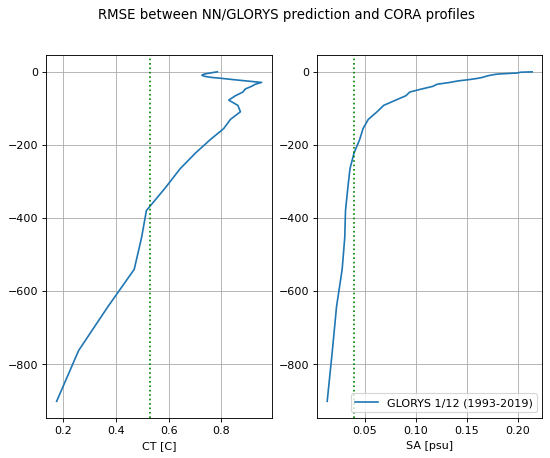

In [8]:
#Plot GLORYS vs NN
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(rmse_from_ae(x_glo['ae_to']), -x_glo['depth'], label='GLORYS 1/12 (2010-2018)')
ax[0].set_xlabel('CT [C]')
#ax[0].axvline(x = 0.806, color = 'red')
ax[0].axvline(x = x_glo['rmse_T_mean'].data, color = 'green', linestyle = 'dotted')
ax[0].grid()

ax[1].plot(rmse_from_ae(x_glo['ae_so']), -x_glo['depth'], label='GLORYS 1/12 (1993-2019)')
ax[1].set_xlabel('SA [psu]')
ax[1].grid()
#ax[1].axvline(x = 0.129, color = 'red')
ax[1].axvline(x = x_glo['rmse_S_mean'].data, color = 'green', linestyle = 'dotted')
plt.legend(loc='lower right')

fig.suptitle(f'RMSE between NN/GLORYS prediction and CORA profiles')
#plt.savefig(pathfig + 'Model_Loss4part_TSgrad.jpeg')

In [9]:
#RMSE by year
def rmse(predictions, targets):
    return np.sqrt(np.mean(((predictions - targets) ** 2), axis=0))

rmse_T = []
rmse_S = []
rmse_MLD = []
nb_prof = []
year_list = []
for year in np.unique(x_glo['TIME'].dt.year.data):
    tmp_ds = x_glo.where(x_glo['TIME'].dt.year==year, drop=True)
    year_list.append(year)
    nb_prof.append(len(tmp_ds.N_PROF))
    print(f"year: {year}, nb prof:{len(tmp_ds.N_PROF)}")
    rmse_T.append(rmse(tmp_ds['CT'], tmp_ds['CT_predicted']))
    rmse_S.append(rmse(tmp_ds['SA'], tmp_ds['SA_predicted']))

year: 1993, nb prof:305
year: 1994, nb prof:138
year: 1995, nb prof:150
year: 1996, nb prof:290
year: 1997, nb prof:444
year: 1998, nb prof:316
year: 1999, nb prof:126


Text(0.5, 0.98, 'RMSE between GLORYS and real data')

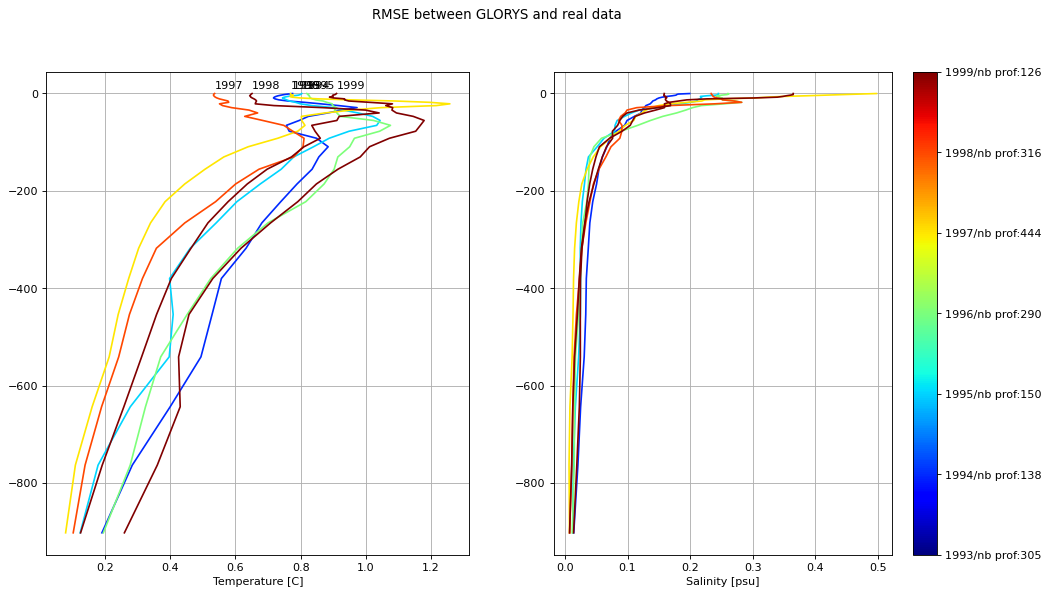

In [10]:
#RMSE by year PLOT
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.min(year_list), vmax=np.max(year_list))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])

labels = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8), dpi=80, facecolor='w', edgecolor='k')

for i in range(len(rmse_T)):
    ax[0].plot(rmse_T[i], -x_glo['depth'], label=year_list[i], c=cmap.to_rgba(year_list[i] + 1))
    ax[0].text(rmse_T[i][0], 10, year_list[i])
    ax[1].plot(rmse_S[i], -x_glo['depth'], label=year_list[i], c=cmap.to_rgba(year_list[i] + 1))
    labels.append(str(f"{year_list[i]}/nb prof:{nb_prof[i]}"))

ax[0].set_xlabel('Temperature [C]')
ax[0].grid()
ax[1].set_xlabel('Salinity [psu]')
ax[1].grid()
cbar = plt.colorbar(cmap, ax=ax[1], ticks=year_list)
cbar.ax.set_yticklabels(labels)
fig.suptitle(f'RMSE between GLORYS and real data')
